PASO 5.1: Captura de Imágenes
Sube al menos 15–20 imágenes del tablero de ajedrez impreso (9x6), tomadas desde distintos ángulos y posiciones, evitando reflejos y asegurándote de que el patrón esté bien enfocado.


Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg
Saving 15.jpg to 15.jpg
Saving 16.jpg to 16.jpg
Saving 17.jpg to 17.jpg
Saving 18.jpg to 18.jpg
Saving 19.jpg to 19.jpg
Saving 20.jpg to 20.jpg
Subiste 20 imágenes.

PASO 5.2: Detección de Esquinas
Esquinas detectadas correctamente en 1.jpg. Imagen guardada como corners_1.jpg.
Esquinas detectadas correctamente en 2.jpg. Imagen guardada como corners_2.jpg.
Esquinas detectadas correctamente en 3.jpg. Imagen guardada como corners_3.jpg.
Esquinas detectadas correctamente en 4.jpg. Imagen guardada como corners_4.jpg.
Esquinas detectadas correctamente en 5.jpg. Imagen guardada como corners_5.jpg.
Esquinas detectadas correctamente en 6.jpg. Imagen guardada como corners_6.jpg.
Esqu

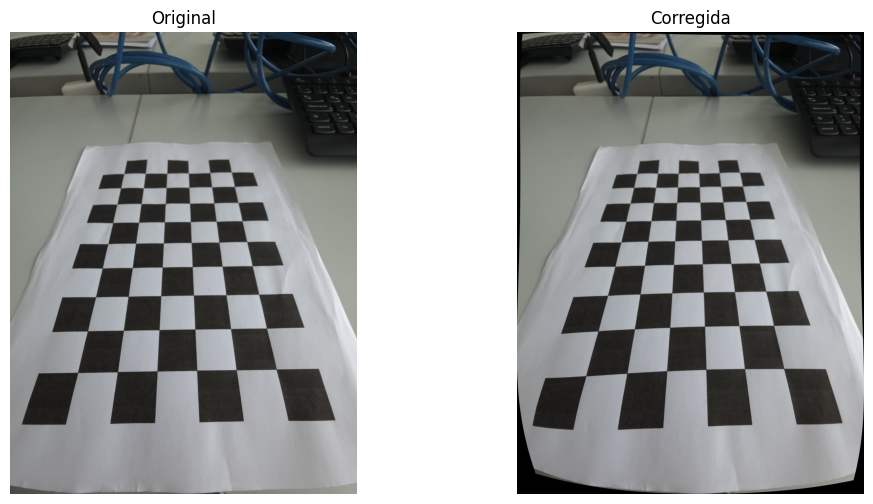

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


PASO EXTRA: Sube un video para aplicar la corrección de distorsión
Selecciona el video en formato .mp4, .avi, etc.


Saving ChessBoard Video.mp4 to ChessBoard Video.mp4


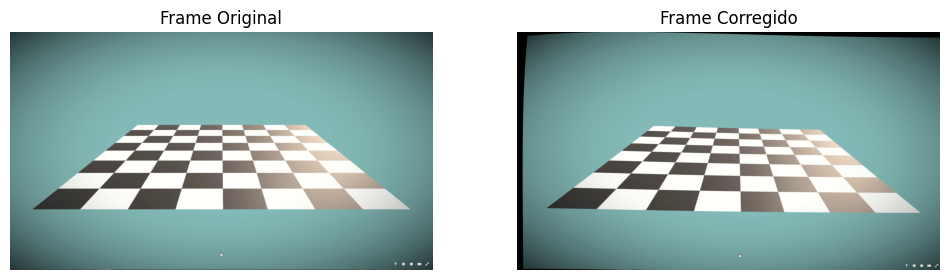

Video corregido guardado como video_undistorted.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

print("PASO 5.1: Captura de Imágenes")
print("Sube al menos 15–20 imágenes del tablero de ajedrez impreso (9x6), tomadas desde distintos ángulos y posiciones, evitando reflejos y asegurándote de que el patrón esté bien enfocado.")
uploaded = files.upload()
print(f"Subiste {len(uploaded)} imágenes.")

chessboard_size = (9, 6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((np.prod(chessboard_size), 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

objpoints = []
imgpoints = []
gray = None
img_shape = None

print("\nPASO 5.2: Detección de Esquinas")
for fname in uploaded:
    img = cv2.imread(fname)
    if img is None:
        print(f"Error al leer la imagen {fname}")
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = gray.shape[::-1]

    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        img_disp = cv2.drawChessboardCorners(img.copy(), chessboard_size, corners2, ret)
        out_name = f"corners_{fname}"
        cv2.imwrite(out_name, img_disp)
        print(f"Esquinas detectadas correctamente en {fname}. Imagen guardada como {out_name}.")
    else:
        print(f"NO se encontraron esquinas en {fname}.")

print(f"\nTotal imágenes con esquinas detectadas: {len(objpoints)}")

print("\nPASO 5.3: Calibración de la cámara")
if len(objpoints) >= 10 and gray is not None:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    print("Matriz de la cámara (mtx):\n", mtx)
    print("Coeficientes de distorsión (dist):\n", dist.ravel())

    print("\nPASO 5.4: Validación")
    total_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        total_error += error
    reproj_error = total_error / len(objpoints)
    print(f"Error promedio de reproyección: {reproj_error:.4f} px (<= 0.5 px es muy bueno)")

    test_img_name = list(uploaded.keys())[0]
    img = cv2.imread(test_img_name)
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    cv2.imwrite('calibrated_result.jpg', dst)
    print(f"Se guardó la imagen corregida como calibrated_result.jpg")

    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Corregida')
    axs[1].axis('off')
    plt.show()

    files.download('calibrated_result.jpg')

    # --- SUBIR Y PROCESAR VIDEO ---
    print("\nPASO EXTRA: Sube un video para aplicar la corrección de distorsión")
    print("Selecciona el video en formato .mp4, .avi, etc.")
    video_files = files.upload()
    video_path = list(video_files.keys())[0]

    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_vid = None
    frame_count = 0
    max_frames_show = 1

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if out_vid is None:
            h, w = frame.shape[:2]
            out_vid = cv2.VideoWriter('video_undistorted.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
        undistorted = cv2.undistort(frame, mtx, dist, None, newcameramtx)
        out_vid.write(undistorted)

        # Visualización de comparación solo en el primer frame
        if frame_count < max_frames_show:
            fig, axs = plt.subplots(1,2, figsize=(12,6))
            axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Frame Original')
            axs[0].axis('off')
            axs[1].imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
            axs[1].set_title('Frame Corregido')
            axs[1].axis('off')
            plt.show()
        frame_count += 1

    cap.release()
    if out_vid is not None:
        out_vid.release()
        print("Video corregido guardado como video_undistorted.mp4")
        files.download('video_undistorted.mp4')
    else:
        print("No se pudo procesar el video correctamente.")
else:
    print("¡No se pudo calibrar! Sube al menos 10 imágenes válidas del tablero.")